In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from scipy import linalg
from sklearn.decomposition import PCA

# go here for the example I followed: https://github.com/nbara/python-meegkit/blob/master/examples/example_mcca.ipynb
# the following CCA functions are from there.

In [2]:
## CCA Functions
def mcca(C, n_channels, n_keep=[]):
    """Multiway canonical correlation analysis.
    As described in [1]_.
    Parameters
    ----------
    C : array, shape=(n_channels * n_datasets, n_channels * n_datasets)
        Covariance matrix of aggregated data sets.
    n_channels : int
        Number of channels of each data set.
    n_keep: int
        Number of components to keep (for orthogonal transforms).
    Returns
    -------
    A : array, shape=(n_channels * n_datasets, n_channels * n_datasets)
        Transform matrix.
    scores : array, shape=(n_comps,)
        Commonality score (ranges from 1 to N^2).
    AA : list of arrays, shapes = (n_channels, n_channels * n_datasets)
        Subject-specific MCCA transform matrices.
    References
    ----------
    .. [1] de Cheveigne, A., Di Liberto, G. M., Arzounian, D., Wong, D.,
       Hjortkjaer, J., Fuglsang, S. A., & Parra, L. C. (2018). Multiway
       Canonical Correlation Analysis of Brain Signals. bioRxiv, 344960.
    """
    if C.shape[0] != C.shape[1]:
        raise ValueError('Covariance must be square !')
    if np.mod(C.shape[0], n_channels) != 0:
        raise ValueError('!')

    # Whiten covariance by blocks
    n_blocks = C.shape[0] // n_channels
    A = np.zeros((n_channels * n_blocks, n_channels * n_blocks))
    for b in range(n_blocks):

        # Extract block covariance
        ix0 = b * n_channels
        ix1 = ix0 + n_channels
        CC = C[ix0:ix1, ix0:ix1]

        # Sphere it
        W = whiten_nt(CC, keep=True)
        A[ix0:ix1, ix0:ix1] = W

    C = A.T.dot(C.dot(A))

    # final PCA
    V, d = pca(C, thresh=None)  # don't threshold the PCA to keep n_channels
    A = A.dot(V)
    C = V.T.dot(C.dot(V))
    scores = np.diag(C)

    AA = []
    for b in range(n_blocks):
        AA.append(A[n_channels * b + np.arange(n_channels), :])

    return A, scores, AA

def whiten_nt(C, thresh=1e-12, keep=False):
    """Covariance whitening function from noisetools.
    Parameters
    ----------
    C : array
        Covariance matrix.
    thresh : float
        PCA threshold.
    keep : bool
        If True, infrathreshold components are set to zero. If False (default),
        infrathreshold components are truncated.
    """
    d, V = linalg.eigh(C)  # eigh if matrix symmetric, eig otherwise
    d = np.real(d)
    V = np.real(V)

    # Sort eigenvalues
    idx = np.argsort(d)[::-1]
    d = d[idx]
    V = V[:, idx]

    # Remove small eigenvalues
    good = (d / np.max(d)) > thresh
    if keep is True:
        d[~good] = 0
        V[:, ~good] = 0
    else:
        d = d[good]
        V = V[:, good]

    # break symmetry when x and y perfectly correlated (otherwise cols of x*A
    # and y*B are not orthogonal)
    d = d ** (1 - thresh)

    dd = np.zeros_like(d)
    dd[d > thresh] = (1. / d[d > thresh])

    D = np.diag(np.sqrt(dd))
    W = np.dot(V, D)

    return W

def pca(cov, max_comps=None, thresh=0):
    """PCA from covariance.
    Parameters
    ----------
    cov:  array, shape=(n_chans, n_chans)
        Covariance matrix.
    max_comps : int | None
        Maximum number of components to retain after decomposition. ``None``
        (the default) keeps all suprathreshold components (see ``thresh``).
    thresh : float
        Discard components below this threshold.
    Returns
    -------
    V : array, shape=(max_comps, max_comps)
        Eigenvectors (matrix of PCA components).
    d : array, shape=(max_comps,)
        PCA eigenvalues
    """
    if thresh is not None and (thresh > 1 or thresh < 0):
        raise ValueError('Threshold must be between 0 and 1 (or None).')

    d, V = linalg.eigh(cov)
    d = d.real
    V = V.real

    p0 = d.sum()  # total power

    idx = np.argsort(d)[::-1]  # reverse sort ev order
    d = d[idx]
    V = V[:, idx]

    # Truncate weak components
    if thresh is not None:
        idx = np.where(d / d.max() > thresh)[0]
        d = d[idx]
        V = V[:, idx]

    # Keep a fixed number of components
    if max_comps is None:
        max_comps = V.shape[1]
    else:
        max_comps = np.min((max_comps, V.shape[1]))

    V = V[:, np.arange(max_comps)]
    d = d[np.arange(max_comps)]

    var = 100 * d.sum() / p0
    if var < 99:
        print('[PCA] Explained variance of selected components : {:.2f}%'.
              format(var))

    return V, d




In [3]:
## Load Dataset
templates = []
# do not keep 'Timestamp'
keep_cols = ['EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8']
#df = trim_cols(load_df('sultan_checkerboard_{}.csv'.format(1)))

def trim_cols(df, keep):
    return df[keep]

for i in range(8):
    templates.append(trim_cols(pd.read_csv('templates/sultan_checkerboard_{}.csv'.format(i+1), skiprows=0, header=1), keep_cols))

In [4]:
## Now I want an input signal to compare with the templates
## For now, I will choose a subset of data from target 1 

# from sklearn.model_selection import train_test_split
# train, test = train_test_split(templates[0], test_size=0.1)
# remove test data from templates
# templates[0] = train

# NOTE: templates[0] is not ordered like the rest after this operation


In [5]:
# cutoff according to shortest length
cutoff_list = [len(templates[i].index) for i in range(8)]
cutoff = min(cutoff_list)
for i in range(8):
    keep_indicies = set(range(templates[i].shape[0])) - set(range(cutoff, templates[i].shape[0]))
    templates[i] = templates[i].take(list(keep_indicies))
    print('length of dataset {} = {}'.format(i+1, len(templates[i].index)))

length of dataset 1 = 3869
length of dataset 2 = 3869
length of dataset 3 = 3869
length of dataset 4 = 3869
length of dataset 5 = 3869
length of dataset 6 = 3869
length of dataset 7 = 3869
length of dataset 8 = 3869


In [6]:
x = np.hstack(templates)
C = np.dot(x.T, x)
print('Aggregated data covariance shape: {}'.format(C.shape))

Aggregated data covariance shape: (32, 32)


In [7]:
## apply CCA
[A, score, AA] = mcca(C, 8)
z = x.dot(A)

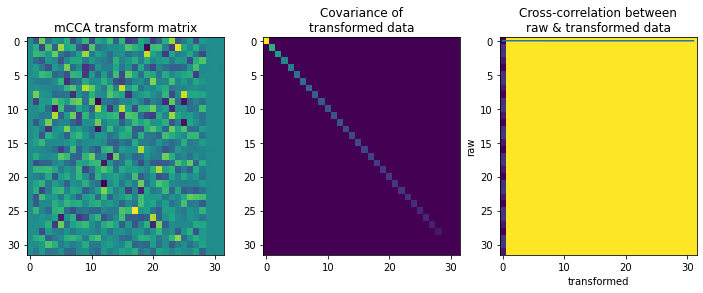

In [8]:
## plot results
f, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(A, aspect='auto')
axes[0].set_title('mCCA transform matrix')
axes[1].imshow(A.T.dot(C.dot(A)), aspect='auto')
axes[1].set_title('Covariance of\ntransformed data')
axes[2].imshow(x.T.dot((x.dot(A))), aspect='auto')
axes[2].set_title('Cross-correlation between\nraw & transformed data')
axes[2].set_xlabel('transformed')
axes[2].set_ylabel('raw')
plt.plot(np.mean(z ** 2, axis=0))
plt.show()

In [9]:
from scipy.fft import fft
from scipy import signal
def plot_fft(template, channel, left, right):
    filt = signal.firwin(400, [0.01, 0.06], pass_zero=False)
    N = len(template.index)
    freq = np.array(template[channel])
    freq = [f - np.average(freq) for f in freq]
    # filter
    freq = signal.convolve(freq, filt, mode='same')
    freq = fft(freq)
    xf = np.linspace(0.0, 1.0/(2.0*(1.0/128)), N//2)
    plt.plot(xf, 2.0/N * np.abs(freq[0:N//2]))
    plt.grid()
    plt.xlim(left=left, right=right)
    plt.show()

In [10]:
def plot_time(template, channel, left, right):
    filt = signal.firwin(400, [0.01, 0.06], pass_zero=False)
    N = len(template.index)
    # sig = np.array(template[channel])
    avg = np.average(template[channel])
    sig = [i - avg for i in template[channel]]
    # filter
    sig = signal.convolve(sig, filt, mode='same')
    plt.plot(sig)
    plt.grid()
    plt.xlim(left=left, right=right)
    plt.show()

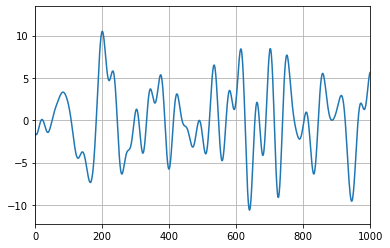

In [11]:
plot_time(templates[1], 'EEG.O2', 0, 1000)

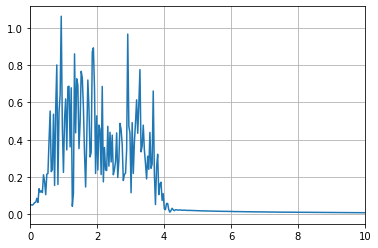

In [12]:
plot_fft(templates[2], 'EEG.O1', 0, 10)

In [13]:
def fft_template(template):
    new_temp = template
    channels = ['EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8']
    for channel in channels:
        # include filtering
        filt = signal.firwin(400, [0.01, 0.06], pass_zero=False)
        N = len(template.index)
        freq = np.array(template[channel])
        freq = [f - np.average(freq) for f in freq]
        # filter
        freq = signal.convolve(freq, filt, mode='same')
        freq = fft(freq)
        new_temp[channel] = freq.real
    return new_temp

In [14]:
for i in range(8):
    templates[i] = fft_template(templates[i])

Aggregated data covariance shape: (32, 32)


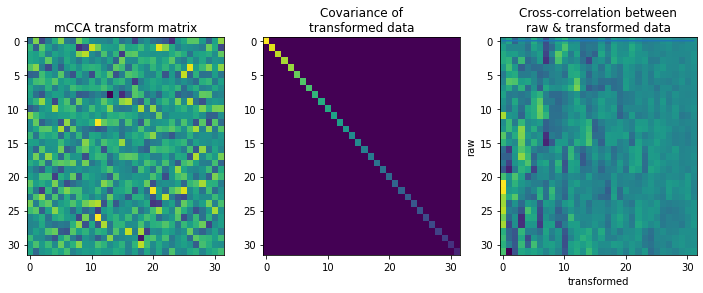

In [15]:
x = np.hstack(templates)
C = np.dot(x.T, x)
print('Aggregated data covariance shape: {}'.format(C.shape))
## apply CCA
[A, score, AA] = mcca(C, 8)
z = x.dot(A)
## plot results
f, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(A, aspect='auto')
axes[0].set_title('mCCA transform matrix')
axes[1].imshow(A.T.dot(C.dot(A)), aspect='auto')
axes[1].set_title('Covariance of\ntransformed data')
axes[2].imshow(x.T.dot((x.dot(A))), aspect='auto')
axes[2].set_title('Cross-correlation between\nraw & transformed data')
axes[2].set_xlabel('transformed')
axes[2].set_ylabel('raw')
plt.plot(np.mean(z ** 2, axis=0))
plt.show()